In [6]:
# ------------------  set up logging ----------------------
import logging
from auditory_cortex.utils import set_up_logging
set_up_logging('info')

import os
import scipy
import numpy as np
import seaborn as sns
from functools import reduce

from auditory_cortex.plotters import tikzplots
from auditory_cortex.analyses import Correlations, STRFCorrelations
from auditory_cortex.plotters.correlation_plotter import RegPlotter
from auditory_cortex.plotters.plotter_utils import PlotterUtils
from auditory_cortex import results_dir
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from palettable.colorbrewer import qualitative
paired_colors = qualitative.Dark2_8.mpl_colors
%matplotlib inline


### perceptual scales..

In [25]:
def slaney_scale(freq):
    min_log_hertz = 1000.0
    min_log_mel = 15.0
    logstep = 27.0 / np.log(6.4)
    mels = 3.0 * freq / 200.0

    if isinstance(freq, np.ndarray):
        log_region = freq >= min_log_hertz
        mels[log_region] = min_log_mel + np.log(freq[log_region] / min_log_hertz) * logstep
    elif freq >= min_log_hertz:
        mels = min_log_mel + np.log(freq / min_log_hertz) * logstep
    return mels

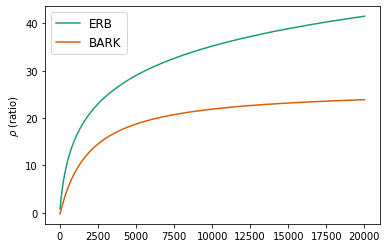

In [24]:
freq_hz = np.linspace(20, 20000, 1000)
erb = 9.265 * np.log(1 + freq_hz / (24.7 * 9.265))

bark = (26.81 * freq_hz) / (1960 + freq_hz) - 0.53

# ------------------  set up figure ----------------------
color = paired_colors[0]
plt.plot(freq_hz, erb, color=color, label='ERB')

color = paired_colors[1]
plt.plot(freq_hz, bark, color=color, label='BARK')

plt.ylabel(r"$\rho$ (ratio)")


plt.legend(loc='upper left', fontsize=12)

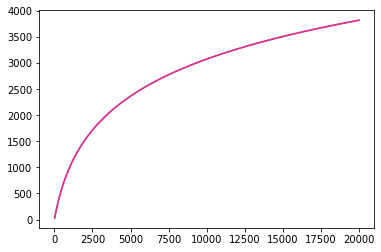

In [13]:
htk = 2595.0 * np.log10(1.0 + (freq_hz / 700.0))
kaldi = 1127.0 * np.log(1.0 + (freq_hz / 700.0))

color = paired_colors[2]
plt.plot(freq_hz, htk, color=color, label='HTK')

color = paired_colors[3]
plt.plot(freq_hz, kaldi, color=color, label='Kaldi')

### strf plots

INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_lib_ucsf_timit_trf_lags200_bw50_regression_improved 0.3687004811378996
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_wavlet_ucsf_timit_trf_lags200_bw50_regression_improved 0.43576601309025814
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_ucsf_timit_trf_lags200_bw50_regression_improved 0.46191797778544125
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_ds_ucsf_timit_trf_lags200_bw50_regression_improved 0.48480005000800114
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_wh_ucsf_timit_trf_lags200_bw50_regression_improved 0.5269198674825601
model_name 'cochleogram' not recognizable!!!
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_coch_ucsf_timit_trf_lags200_bw50_regression_improved 0.5350408969767726
INFO:Filtering 'mVoc

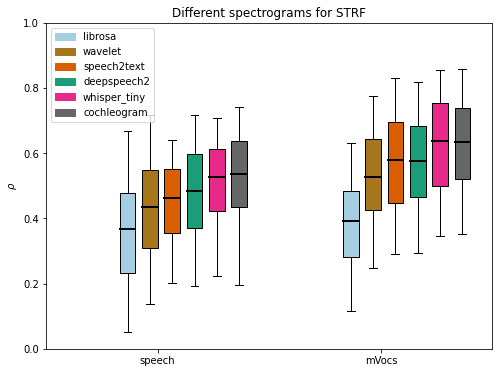

In [8]:
save_tikz=True
threshold =0.5
lag = 200

area = 'all'
bin_width = 50
delay = 0
normalized=True
model_name = 'STRF_freqs80'

timit_identifiers = {
    'librosa': f'mel_lib_ucsf_timit_trf_lags{lag}_bw{bin_width}_regression_improved',
    'wavelet': f'wavlet_ucsf_timit_trf_lags{lag}_bw{bin_width}_regression_improved',
    'speech2text': f'mel_ucsf_timit_trf_lags{lag}_bw{bin_width}_regression_improved',
    'deepspeech2': f'mel_ds_ucsf_timit_trf_lags{lag}_bw{bin_width}_regression_improved',
    'whisper_tiny': f'mel_wh_ucsf_timit_trf_lags{lag}_bw{bin_width}_regression_improved',       # whisper STRF
    'cochleogram': f'coch_ucsf_timit_trf_lags{lag}_bw{bin_width}_regression_improved',
}
mVocs_identifiers = {
    'librosa': f'mel_lib_ucsf_mVocs_trf_lags{lag}_bw{bin_width}_regression_improved',
    'wavelet': f'wavlet_ucsf_mVocs_trf_lags{lag}_bw{bin_width}_regression_improved',              # wavelet STRF
    'speech2text': f'mel_ucsf_mVocs_trf_lags{lag}_bw{bin_width}_regression_improved',             # speech2text STRF
    'deepspeech2': f'mel_ds_ucsf_mVocs_trf_lags{lag}_bw{bin_width}_regression_improved',     # deepspeechs STRF
    'whisper_tiny': f'mel_wh_ucsf_mVocs_trf_lags{lag}_bw{bin_width}_regression_improved',       # whisper STRF
    'cochleogram': f'coch_ucsf_mVocs_trf_lags{lag}_bw{bin_width}_regression_improved',
}
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.35
spacing = 0.5
groups_distance = 5
legends = []
indices = []
alpha = 1
group_locations = np.array([0, groups_distance])
mVocs = False
group = group_locations[0]
for idx, (label, iden) in enumerate(timit_identifiers.items()):
    if label == 'wavelet':
        color = PlotterUtils.colors[-2]
    elif label == 'librosa':
        color = paired_colors[0]
    else:
        color = PlotterUtils.get_model_specific_color(label)
    baseline_identifier = model_name + '_' + iden
    strf_obj = STRFCorrelations(baseline_identifier)
    baseline_dist = strf_obj.get_correlations_for_bin_width(
        neural_area=area, bin_width=bin_width, delay=delay,
        threshold=threshold, normalized=normalized, mVocs=mVocs,
        lag=None,   # saying lag=0.3
    )
    print(f"{baseline_identifier} {np.median(baseline_dist)}")
    indices.append(group+(idx*spacing)-width/2)
    ax.boxplot(
        baseline_dist,
        positions=[indices[-1]], widths=width,
        patch_artist=True,
        boxprops=dict(facecolor=color, alpha=alpha),
        medianprops = dict(color='k', linewidth=2), whis=[5, 95],
        showfliers=False,
        )
    legends.append(
        # Line2D([0], [0], color=color, lw=2, label=label,),
        Patch(color=color, label=label),
    )
mVocs = True
group = group_locations[1]
for idx, (label, iden) in enumerate(mVocs_identifiers.items()):
    if label == 'wavelet':
        color = PlotterUtils.colors[-2]
    elif label == 'librosa':
        color = paired_colors[0]
    else:
        color = PlotterUtils.get_model_specific_color(label)
    baseline_identifier = model_name + '_' + iden
    strf_obj = STRFCorrelations(baseline_identifier)
    baseline_dist = strf_obj.get_correlations_for_bin_width(
        neural_area=area, bin_width=bin_width, delay=delay,
        threshold=threshold, normalized=normalized, mVocs=mVocs,
        lag=None,   # saying lag=0.3
    )
    indices.append(group+(idx*spacing)-width/2)
    print(f"{baseline_identifier} {np.median(baseline_dist)}")
    ax.boxplot(
        baseline_dist,
        positions=[indices[-1]],
        widths=width,
        patch_artist=True,
        boxprops=dict(facecolor=color, alpha=alpha),
        medianprops = dict(color='k', linewidth=2),
        whis=[5, 95],
        showfliers=False,
        )
x_tick_labels = timit_identifiers.keys()
ax.set_xticks(group_locations+spacing, ['speech', 'mVocs'], rotation=0, ha="center")
ax.legend(handles=legends, loc='best')
ax.set_ylabel(f"$\\rho$")
ax.set_title(f"Different spectrograms for STRF")
ax.set_ylim(0.0, 1.0)
ax.set_xlim(-2, 8)
if save_tikz:
    filepath = os.path.join(
        results_dir,
        'tikz_plots',
        f"gap-{threshold}-spectrograms-comparison-trf{lag}.tex"
        )
    PlotterUtils.save_tikz(filepath)

### Millet & King spectrogram

model_name 'librosa' not recognizable!!!
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_lib_ucsf_timit_trf_lags200_bw50_regression_improved 0.3687004811378996
model_name 'librosa_log' not recognizable!!!
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_lib_ucsf_timit_trf_lags200_bw50_regression_improved_log10 0.5223684943089376
model_name 'cochleogram' not recognizable!!!
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_coch_ucsf_timit_trf_lags200_bw50_regression_improved 0.5350408969767726
model_name 'librosa' not recognizable!!!
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_lib_ucsf_mVocs_trf_lags200_bw50_regression_improved 0.3924787987411979
model_name 'librosa_log' not recognizable!!!
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_lib_ucsf_mVocs_trf_lags200_bw50_regression_improved_lo

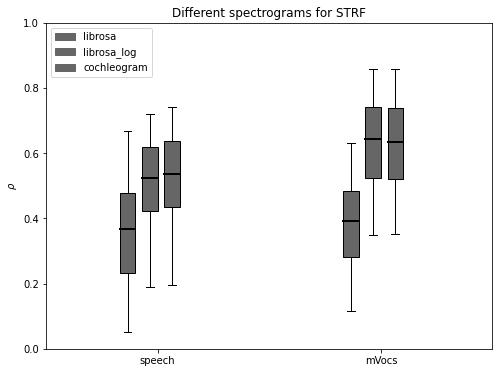

In [5]:
save_tikz=False
threshold =0.5
lag = 200

area = 'all'
bin_width = 50
delay = 0
normalized=True
model_name = 'STRF_freqs80'

timit_identifiers = {
    'librosa': f'mel_lib_ucsf_timit_trf_lags{lag}_bw{bin_width}_regression_improved',
    'librosa_log': f'mel_lib_ucsf_timit_trf_lags{lag}_bw{bin_width}_regression_improved_log10',
    'cochleogram': f'coch_ucsf_timit_trf_lags{lag}_bw{bin_width}_regression_improved',
}
mVocs_identifiers = {
    'librosa': f'mel_lib_ucsf_mVocs_trf_lags{lag}_bw{bin_width}_regression_improved',
    'librosa_log': f'mel_lib_ucsf_mVocs_trf_lags{lag}_bw{bin_width}_regression_improved_log10',
    'cochleogram': f'coch_ucsf_mVocs_trf_lags{lag}_bw{bin_width}_regression_improved',
}
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.35
spacing = 0.5
groups_distance = 5
legends = []
indices = []
alpha = 1
group_locations = np.array([0, groups_distance])
mVocs = False
group = group_locations[0]
for idx, (label, iden) in enumerate(timit_identifiers.items()):
    if label == 'wavelet':
        color = PlotterUtils.colors[-2]
    else:
        color = PlotterUtils.get_model_specific_color(label)
    baseline_identifier = model_name + '_' + iden
    strf_obj = STRFCorrelations(baseline_identifier)
    baseline_dist = strf_obj.get_correlations_for_bin_width(
        neural_area=area, bin_width=bin_width, delay=delay,
        threshold=threshold, normalized=normalized, mVocs=mVocs,
        lag=None,   # saying lag=0.3
    )
    print(f"{baseline_identifier} {np.median(baseline_dist)}")
    indices.append(group+(idx*spacing)-width/2)
    ax.boxplot(
        baseline_dist,
        positions=[indices[-1]], widths=width,
        patch_artist=True,
        boxprops=dict(facecolor=color, alpha=alpha),
        medianprops = dict(color='k', linewidth=2), whis=[5, 95],
        showfliers=False,
        )
    legends.append(
        # Line2D([0], [0], color=color, lw=2, label=label,),
        Patch(color=color, label=label),
    )
mVocs = True
group = group_locations[1]
for idx, (label, iden) in enumerate(mVocs_identifiers.items()):
    if label == 'wavelet':
        color = PlotterUtils.colors[-2]
    else:
        color = PlotterUtils.get_model_specific_color(label)
    baseline_identifier = model_name + '_' + iden
    strf_obj = STRFCorrelations(baseline_identifier)
    baseline_dist = strf_obj.get_correlations_for_bin_width(
        neural_area=area, bin_width=bin_width, delay=delay,
        threshold=threshold, normalized=normalized, mVocs=mVocs,
        lag=None,   # saying lag=0.3
    )
    indices.append(group+(idx*spacing)-width/2)
    print(f"{baseline_identifier} {np.median(baseline_dist)}")
    ax.boxplot(
        baseline_dist,
        positions=[indices[-1]],
        widths=width,
        patch_artist=True,
        boxprops=dict(facecolor=color, alpha=alpha),
        medianprops = dict(color='k', linewidth=2),
        whis=[5, 95],
        showfliers=False,
        )
x_tick_labels = timit_identifiers.keys()
ax.set_xticks(group_locations+spacing, ['speech', 'mVocs'], rotation=0, ha="center")
ax.legend(handles=legends, loc='best')
ax.set_ylabel(f"$\\rho$")
ax.set_title(f"Different spectrograms for STRF")
ax.set_ylim(0.0, 1.0)
ax.set_xlim(-2, 8)
if save_tikz:
    filepath = os.path.join(
        results_dir,
        'tikz_plots',
        f"gap-{threshold}-spectrograms-comparison-trf{lag}.tex"
        )
    PlotterUtils.save_tikz(filepath)

### summary

In [7]:
save_tikz=False
threshold = 0.5

area = 'all'
bin_width = 50
delay = 0
normalized=True
model_name = 'STRF_freqs80'
timit_identifiers = {
    'wavelet': 'wavlet_timit_trf_lags300_bw50_naplib_matched',              # wavelet STRF
    'speech2text': 'mel_timit_trf_lags300_bw50_naplib_matched',             # speech2text STRF
    'deepspeech2': 'mel_ds_ucsf_timit_trf_lags300_bw50_naplib_matched',     # deepspeechs STRF
    'whisper_tiny': 'mel_wh_ucsf_timit_trf_lags300_bw50_naplib_matched',         # whisper STRF
}
mVocs_identifiers = {
    # 'wavelet': 'wavlet_mVocs_trf_lags300_bw50_naplib_matched',              # wavelet STRF
    'whisper_padded': 'mel_wh_ucsf_mVocs_trf_lags300_bw50_padded_features',
    'speech2text': 'mel_mVocs_trf_lags300_bw50_naplib_matched',             # speech2text STRF
    'deepspeech2': 'mel_ds_ucsf_mVocs_trf_lags300_bw50_naplib_matched',     # deepspeechs STRF
    'whisper_tiny': 'mel_wh_ucsf_mVocs_trf_lags300_bw50_naplib_matched',         # whisper STRF
}


model_name 'wavelet' not recognizable!!!
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_wavlet_timit_trf_lags300_bw50_naplib_matched 0.3930658747795468
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_timit_trf_lags300_bw50_naplib_matched 0.44092188925403497
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_ds_ucsf_timit_trf_lags300_bw50_naplib_matched 0.404549754105609
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_wh_ucsf_timit_trf_lags300_bw50_naplib_matched 0.4831611470654496
model_name 'whisper_padded' not recognizable!!!
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_wh_ucsf_mVocs_trf_lags300_bw50_padded_features 0.6189292231425134
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_mVocs_trf_lags300_bw50_naplib_matched 0.3362699088496129
INFO:Filterin

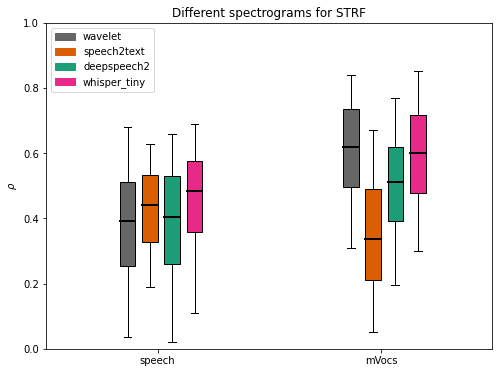

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.35
spacing = 0.5
groups_distance = 5
legends = []
indices = []
alpha = 1
group_locations = np.array([0, groups_distance])
mVocs = False
group = group_locations[0]
for idx, (label, iden) in enumerate(timit_identifiers.items()):
    color = PlotterUtils.get_model_specific_color(label)
    baseline_identifier = model_name + '_' + iden
    strf_obj = STRFCorrelations(baseline_identifier)
    baseline_dist = strf_obj.get_correlations_for_bin_width(
        neural_area=area, bin_width=bin_width, delay=delay,
        threshold=threshold, normalized=normalized, mVocs=mVocs,
        lag=None,   # saying lag=0.3
    )
    print(f"{baseline_identifier} {np.median(baseline_dist)}")
    indices.append(group+(idx*spacing)-width/2)
    ax.boxplot(
        baseline_dist,
        positions=[indices[-1]], widths=width,
        patch_artist=True,
        boxprops=dict(facecolor=color, alpha=alpha),
        medianprops = dict(color='k', linewidth=2), whis=[5, 95],
        showfliers=False,
        )
    legends.append(
        # Line2D([0], [0], color=color, lw=2, label=label,),
        Patch(color=color, label=label),
    )
mVocs = True
group = group_locations[1]
for idx, (label, iden) in enumerate(mVocs_identifiers.items()):
    color = PlotterUtils.get_model_specific_color(label)
    baseline_identifier = model_name + '_' + iden
    strf_obj = STRFCorrelations(baseline_identifier)
    baseline_dist = strf_obj.get_correlations_for_bin_width(
        neural_area=area, bin_width=bin_width, delay=delay,
        threshold=threshold, normalized=normalized, mVocs=mVocs,
        lag=None,   # saying lag=0.3
    )
    print(f"{baseline_identifier} {np.median(baseline_dist)}")
    indices.append(group+(idx*spacing)-width/2)
    ax.boxplot(
        baseline_dist,
        positions=[indices[-1]],
        widths=width,
        patch_artist=True,
        boxprops=dict(facecolor=color, alpha=alpha),
        medianprops = dict(color='k', linewidth=2),
        whis=[5, 95],
        showfliers=False,
        )
x_tick_labels = timit_identifiers.keys()
ax.set_xticks(group_locations+spacing, ['speech', 'mVocs'], rotation=0, ha="center")
ax.legend(handles=legends, loc='best')
ax.set_ylabel(f"$\\rho$")
ax.set_title(f"Different spectrograms for STRF")
ax.set_ylim(0.0, 1.0)
ax.set_xlim(-2, 8)
if save_tikz:
    filepath = os.path.join(
        results_dir,
        'tikz_plots',
        f"gap-{threshold}-spectrograms-comparison.tex"
        )
    PlotterUtils.save_tikz(filepath)

### STRF window sizes..

#### speech2text

In [2]:
save_tikz=False
threshold = 0.5

area = 'all'
bin_width = 50
delay = 0
normalized=True
model_name = 'STRF_freqs80'
timit_identifiers = {
    'speech2text': 'mel_wh_ucsf_timit_trf_lags200_bw50_regression_improved',
}
mVocs_identifiers = {
    'wavlet': 'wavlet_ucsf_mVocs_trf_lags200_bw50_regression_improved',
    'speech2text_50': 'mel_ucsf_mVocs_trf_lags50_bw50_regression_improved_lmbda_wide',
    'speech2text_100': 'mel_ucsf_mVocs_trf_lags100_bw50_regression_improved_lmbda_wide',
    'speech2text_200': 'mel_ucsf_mVocs_trf_lags200_bw50_regression_improved_lmbda_wide',
    'speech2text_300': 'mel_ucsf_mVocs_trf_lags300_bw50_regression_improved_lmbda_wide',
    
}


INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_wh_ucsf_timit_trf_lags200_bw50_regression_improved 0.5269198674825601
model_name 'wavlet' not recognizable!!!
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_wavlet_ucsf_mVocs_trf_lags200_bw50_regression_improved 0.5264882198310951
model_name 'speech2text_50' not recognizable!!!
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_ucsf_mVocs_trf_lags50_bw50_regression_improved_lmbda_wide 0.4480541886612162
model_name 'speech2text_100' not recognizable!!!
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_ucsf_mVocs_trf_lags100_bw50_regression_improved_lmbda_wide 0.537195078546072
model_name 'speech2text_200' not recognizable!!!
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_ucsf_mVocs_trf_lags200_bw50_regression_improved_lmbda_wide 0.56338

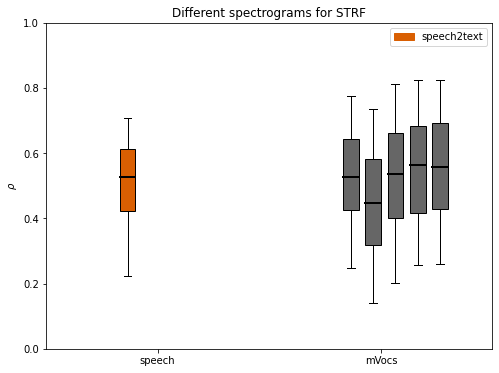

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.35
spacing = 0.5
groups_distance = 5
legends = []
indices = []
alpha = 1
group_locations = np.array([0, groups_distance])
mVocs = False
group = group_locations[0]
for idx, (label, iden) in enumerate(timit_identifiers.items()):
    color = PlotterUtils.get_model_specific_color(label)
    baseline_identifier = model_name + '_' + iden
    strf_obj = STRFCorrelations(baseline_identifier)
    baseline_dist = strf_obj.get_correlations_for_bin_width(
        neural_area=area, bin_width=bin_width, delay=delay,
        threshold=threshold, normalized=normalized, mVocs=mVocs,
        lag=None,   # saying lag=0.3
    )
    print(f"{baseline_identifier} {np.median(baseline_dist)}")
    indices.append(group+(idx*spacing)-width/2)
    ax.boxplot(
        baseline_dist,
        positions=[indices[-1]], widths=width,
        patch_artist=True,
        boxprops=dict(facecolor=color, alpha=alpha),
        medianprops = dict(color='k', linewidth=2), whis=[5, 95],
        showfliers=False,
        )
    legends.append(
        # Line2D([0], [0], color=color, lw=2, label=label,),
        Patch(color=color, label=label),
    )
mVocs = True
group = group_locations[1]
for idx, (label, iden) in enumerate(mVocs_identifiers.items()):
    color = PlotterUtils.get_model_specific_color(label)
    baseline_identifier = model_name + '_' + iden
    strf_obj = STRFCorrelations(baseline_identifier)
    baseline_dist = strf_obj.get_correlations_for_bin_width(
        neural_area=area, bin_width=bin_width, delay=delay,
        threshold=threshold, normalized=normalized, mVocs=mVocs,
        lag=None,   # saying lag=0.3
    )
    print(f"{baseline_identifier} {np.median(baseline_dist)}")
    indices.append(group+(idx*spacing)-width/2)
    ax.boxplot(
        baseline_dist,
        positions=[indices[-1]],
        widths=width,
        patch_artist=True,
        boxprops=dict(facecolor=color, alpha=alpha),
        medianprops = dict(color='k', linewidth=2),
        whis=[5, 95],
        showfliers=False,
        )
x_tick_labels = timit_identifiers.keys()
ax.set_xticks(group_locations+spacing, ['speech', 'mVocs'], rotation=0, ha="center")
ax.legend(handles=legends, loc='best')
ax.set_ylabel(f"$\\rho$")
ax.set_title(f"Different spectrograms for STRF")
ax.set_ylim(0.0, 1.0)
ax.set_xlim(-2, 8)
if save_tikz:
    filepath = os.path.join(
        results_dir,
        'tikz_plots',
        f"gap-{threshold}-spectrograms-comparison.tex"
        )
    PlotterUtils.save_tikz(filepath)

#### whisper

In [4]:
save_tikz=True
threshold = 0.5

area = 'all'
bin_width = 50
delay = 0
normalized=True
model_name = 'STRF_freqs80'
timit_identifiers = {
    # mel_wh_ucsf_timit_trf_lags50_bw50_regression_improved
    'whisper_reg_50': 'mel_wh_ucsf_timit_trf_lags50_bw50_regression_improved',
    'whisper_reg_100': 'mel_wh_ucsf_timit_trf_lags100_bw50_regression_improved',
    'whisper_reg_200': 'mel_wh_ucsf_timit_trf_lags200_bw50_regression_improved',
    'whisper_reg_300': 'mel_wh_ucsf_timit_trf_lags300_bw50_regression_improved',    # whisper STRF
    'whisper_reg_400': 'mel_wh_ucsf_timit_trf_lags400_bw50_regression_improved',    # whisper STRF
    'whisper_reg_500': 'mel_wh_ucsf_timit_trf_lags500_bw50_regression_improved',    # whisper STRF
    'whisper_reg_600': 'mel_wh_ucsf_timit_trf_lags600_bw50_regression_improved',    # whisper STRF
}
mVocs_identifiers = {
    # 'wavelet_200': 'wavlet_ucsf_mVocs_trf_lags200_bw50_regression_improved',
    'whisper_reg_50': 'mel_wh_ucsf_mVocs_trf_lags50_bw50_regression_improved',
    'whisper_reg_100': 'mel_wh_ucsf_mVocs_trf_lags100_bw50_regression_improved',
    'whisper_reg_200': 'mel_wh_ucsf_mVocs_trf_lags200_bw50_regression_improved',
    'whisper_reg_300': 'mel_wh_ucsf_mVocs_trf_lags300_bw50_regression_improved',
    'whisper_reg_400': 'mel_wh_ucsf_mVocs_trf_lags400_bw50_regression_improved',
    'whisper_reg_500': 'mel_wh_ucsf_mVocs_trf_lags500_bw50_regression_improved',
    'whisper_reg_600': 'mel_wh_ucsf_mVocs_trf_lags600_bw50_regression_improved',
}


model_name 'whisper_reg_50' not recognizable!!!
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_wh_ucsf_timit_trf_lags50_bw50_regression_improved 0.4952501367854381
model_name 'whisper_reg_100' not recognizable!!!
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_wh_ucsf_timit_trf_lags100_bw50_regression_improved 0.5155436735794916
model_name 'whisper_reg_200' not recognizable!!!
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_wh_ucsf_timit_trf_lags200_bw50_regression_improved 0.5269198674825601
model_name 'whisper_reg_300' not recognizable!!!
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_wh_ucsf_timit_trf_lags300_bw50_regression_improved 0.5320433926375367
model_name 'whisper_reg_400' not recognizable!!!
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_wh_ucsf_timit_trf_lags400_bw50_regression_impro

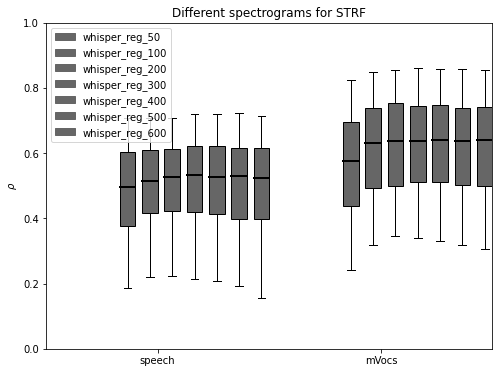

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.35
spacing = 0.5
groups_distance = 5
legends = []
indices = []
alpha = 1
group_locations = np.array([0, groups_distance])
mVocs = False
group = group_locations[0]
for idx, (label, iden) in enumerate(timit_identifiers.items()):
    color = PlotterUtils.get_model_specific_color(label)
    baseline_identifier = model_name + '_' + iden
    strf_obj = STRFCorrelations(baseline_identifier)
    baseline_dist = strf_obj.get_correlations_for_bin_width(
        neural_area=area, bin_width=bin_width, delay=delay,
        threshold=threshold, normalized=normalized, mVocs=mVocs,
        lag=None,   # saying lag=0.3
    )
    print(f"{baseline_identifier} {np.median(baseline_dist)}")
    indices.append(group+(idx*spacing)-width/2)
    ax.boxplot(
        baseline_dist,
        positions=[indices[-1]], widths=width,
        patch_artist=True,
        boxprops=dict(facecolor=color, alpha=alpha),
        medianprops = dict(color='k', linewidth=2), whis=[5, 95],
        showfliers=False,
        )
    legends.append(
        # Line2D([0], [0], color=color, lw=2, label=label,),
        Patch(color=color, label=label),
    )
mVocs = True
group = group_locations[1]
for idx, (label, iden) in enumerate(mVocs_identifiers.items()):
    color = PlotterUtils.get_model_specific_color(label)
    baseline_identifier = model_name + '_' + iden
    strf_obj = STRFCorrelations(baseline_identifier)
    baseline_dist = strf_obj.get_correlations_for_bin_width(
        neural_area=area, bin_width=bin_width, delay=delay,
        threshold=threshold, normalized=normalized, mVocs=mVocs,
        lag=None,   # saying lag=0.3
    )
    print(f"{baseline_identifier} {np.median(baseline_dist)}")
    indices.append(group+(idx*spacing)-width/2)
    ax.boxplot(
        baseline_dist,
        positions=[indices[-1]],
        widths=width,
        patch_artist=True,
        boxprops=dict(facecolor=color, alpha=alpha),
        medianprops = dict(color='k', linewidth=2),
        whis=[5, 95],
        showfliers=False,
        )
x_tick_labels = timit_identifiers.keys()
ax.set_xticks(group_locations+spacing, ['speech', 'mVocs'], rotation=0, ha="center")
ax.legend(handles=legends, loc='best')
ax.set_ylabel(f"$\\rho$")
ax.set_title(f"Different spectrograms for STRF")
ax.set_ylim(0.0, 1.0)
ax.set_xlim(-2, 8)
if save_tikz:
    filepath = os.path.join(
        results_dir,
        'tikz_plots',
        f"gap-{threshold}-spectrograms-comparison.tex"
        )
    PlotterUtils.save_tikz(filepath)

### trf-100

model_name 'wavelet' not recognizable!!!
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_wavlet_ucsf_timit_trf_lags50_bw50_regression_improved 0.4204104004071
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_ucsf_timit_trf_lags50_bw50_regression_improved 0.43387529334256864
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_ds_ucsf_timit_trf_lags50_bw50_regression_improved 0.46386321759988847
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_wh_ucsf_timit_trf_lags50_bw50_regression_improved 0.4952501367854381
model_name 'wavelet' not recognizable!!!
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_wavlet_ucsf_mVocs_trf_lags50_bw50_regression_improved 0.4884314204330195
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
STRF_freqs80_mel_ucsf_mVocs_trf_lags50_bw50_regression_improved 0.

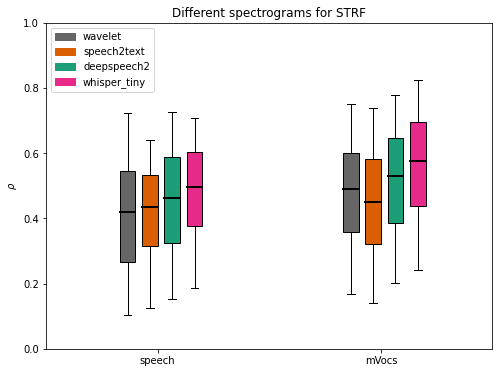

In [2]:
save_tikz=False
threshold = 0.5

area = 'all'
bin_width = 50
delay = 0
normalized=True
model_name = 'STRF_freqs80'
lag = 50
timit_identifiers = {
    'wavelet': f'wavlet_ucsf_timit_trf_lags{lag}_bw{bin_width}_regression_improved',
    'speech2text': f'mel_ucsf_timit_trf_lags{lag}_bw{bin_width}_regression_improved',
    'deepspeech2': f'mel_ds_ucsf_timit_trf_lags{lag}_bw{bin_width}_regression_improved',
    'whisper_tiny': f'mel_wh_ucsf_timit_trf_lags{lag}_bw{bin_width}_regression_improved',       # whisper STRF
    # 'cochleogram': f'coch_ucsf_timit_trf_lags{lag}_bw{bin_width}_regression_improved',
}
mVocs_identifiers = {
    'wavelet': f'wavlet_ucsf_mVocs_trf_lags{lag}_bw{bin_width}_regression_improved',              # wavelet STRF
    'speech2text': f'mel_ucsf_mVocs_trf_lags{lag}_bw{bin_width}_regression_improved',             # speech2text STRF
    'deepspeech2': f'mel_ds_ucsf_mVocs_trf_lags{lag}_bw{bin_width}_regression_improved',     # deepspeechs STRF
    'whisper_tiny': f'mel_wh_ucsf_mVocs_trf_lags{lag}_bw{bin_width}_regression_improved',       # whisper STRF
    # 'cochleogram': f'coch_ucsf_mVocs_trf_lags{lag}_bw{bin_width}_regression_improved',
}
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.35
spacing = 0.5
groups_distance = 5
legends = []
indices = []
alpha = 1
group_locations = np.array([0, groups_distance])
mVocs = False
group = group_locations[0]
for idx, (label, iden) in enumerate(timit_identifiers.items()):
    color = PlotterUtils.get_model_specific_color(label)
    baseline_identifier = model_name + '_' + iden
    strf_obj = STRFCorrelations(baseline_identifier)
    baseline_dist = strf_obj.get_correlations_for_bin_width(
        neural_area=area, bin_width=bin_width, delay=delay,
        threshold=threshold, normalized=normalized, mVocs=mVocs,
        lag=None,   # saying lag=0.3
    )
    print(f"{baseline_identifier} {np.median(baseline_dist)}")
    indices.append(group+(idx*spacing)-width/2)
    ax.boxplot(
        baseline_dist,
        positions=[indices[-1]], widths=width,
        patch_artist=True,
        boxprops=dict(facecolor=color, alpha=alpha),
        medianprops = dict(color='k', linewidth=2), whis=[5, 95],
        showfliers=False,
        )
    legends.append(
        # Line2D([0], [0], color=color, lw=2, label=label,),
        Patch(color=color, label=label),
    )
mVocs = True
group = group_locations[1]
for idx, (label, iden) in enumerate(mVocs_identifiers.items()):
    color = PlotterUtils.get_model_specific_color(label)
    baseline_identifier = model_name + '_' + iden
    strf_obj = STRFCorrelations(baseline_identifier)
    baseline_dist = strf_obj.get_correlations_for_bin_width(
        neural_area=area, bin_width=bin_width, delay=delay,
        threshold=threshold, normalized=normalized, mVocs=mVocs,
        lag=None,   # saying lag=0.3
    )
    indices.append(group+(idx*spacing)-width/2)
    print(f"{baseline_identifier} {np.median(baseline_dist)}")
    ax.boxplot(
        baseline_dist,
        positions=[indices[-1]],
        widths=width,
        patch_artist=True,
        boxprops=dict(facecolor=color, alpha=alpha),
        medianprops = dict(color='k', linewidth=2),
        whis=[5, 95],
        showfliers=False,
        )
x_tick_labels = timit_identifiers.keys()
ax.set_xticks(group_locations+spacing, ['speech', 'mVocs'], rotation=0, ha="center")
ax.legend(handles=legends, loc='best')
ax.set_ylabel(f"$\\rho$")
ax.set_title(f"Different spectrograms for STRF")
ax.set_ylim(0.0, 1.0)
ax.set_xlim(-2, 8)
if save_tikz:
    filepath = os.path.join(
        results_dir,
        'tikz_plots',
        f"gap-{threshold}-spectrograms-comparison-trf-100.tex"
        )
    PlotterUtils.save_tikz(filepath)

### trf-250

In [ ]:
save_tikz=False
threshold = 0.5
lag = 200

area = 'all'
bin_width = 50
delay = 0
normalized=True
model_name = 'STRF_freqs80'

timit_identifiers = {
    'wavelet': f'wavlet_ucsf_timit_trf_lags{lag}_bw{bin_width}_regression_improved',
    'speech2text': f'mel_ucsf_timit_trf_lags{lag}_bw{bin_width}_regression_improved',
    'deepspeech2': f'mel_ds_ucsf_timit_trf_lags{lag}_bw{bin_width}_regression_improved',
    'whisper_tiny': f'mel_wh_ucsf_timit_trf_lags{lag}_bw{bin_width}_regression_improved',       # whisper STRF
    # 'cochleogram': f'coch_ucsf_timit_trf_lags{lag}_bw{bin_width}_regression_improved',
}
mVocs_identifiers = {
    'wavelet': f'wavlet_ucsf_mVocs_trf_lags{lag}_bw{bin_width}_regression_improved',              # wavelet STRF
    'speech2text': f'mel_ucsf_mVocs_trf_lags{lag}_bw{bin_width}_regression_improved',             # speech2text STRF
    'deepspeech2': f'mel_ds_ucsf_mVocs_trf_lags{lag}_bw{bin_width}_regression_improved',     # deepspeechs STRF
    'whisper_tiny': f'mel_wh_ucsf_mVocs_trf_lags{lag}_bw{bin_width}_regression_improved',       # whisper STRF
    # 'cochleogram': f'coch_ucsf_mVocs_trf_lags{lag}_bw{bin_width}_regression_improved',
}
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.35
spacing = 0.5
groups_distance = 5
legends = []
indices = []
alpha = 1
group_locations = np.array([0, groups_distance])
mVocs = False
group = group_locations[0]
for idx, (label, iden) in enumerate(timit_identifiers.items()):
    color = PlotterUtils.get_model_specific_color(label)
    baseline_identifier = model_name + '_' + iden
    strf_obj = STRFCorrelations(baseline_identifier)
    baseline_dist = strf_obj.get_correlations_for_bin_width(
        neural_area=area, bin_width=bin_width, delay=delay,
        threshold=threshold, normalized=normalized, mVocs=mVocs,
        lag=None,   # saying lag=0.3
    )
    print(f"{baseline_identifier} {np.median(baseline_dist)}")
    indices.append(group+(idx*spacing)-width/2)
    ax.boxplot(
        baseline_dist,
        positions=[indices[-1]], widths=width,
        patch_artist=True,
        boxprops=dict(facecolor=color, alpha=alpha),
        medianprops = dict(color='k', linewidth=2), whis=[5, 95],
        showfliers=False,
        )
    legends.append(
        # Line2D([0], [0], color=color, lw=2, label=label,),
        Patch(color=color, label=label),
    )
mVocs = True
group = group_locations[1]
for idx, (label, iden) in enumerate(mVocs_identifiers.items()):
    color = PlotterUtils.get_model_specific_color(label)
    baseline_identifier = model_name + '_' + iden
    strf_obj = STRFCorrelations(baseline_identifier)
    baseline_dist = strf_obj.get_correlations_for_bin_width(
        neural_area=area, bin_width=bin_width, delay=delay,
        threshold=threshold, normalized=normalized, mVocs=mVocs,
        lag=None,   # saying lag=0.3
    )
    indices.append(group+(idx*spacing)-width/2)
    print(f"{baseline_identifier} {np.median(baseline_dist)}")
    ax.boxplot(
        baseline_dist,
        positions=[indices[-1]],
        widths=width,
        patch_artist=True,
        boxprops=dict(facecolor=color, alpha=alpha),
        medianprops = dict(color='k', linewidth=2),
        whis=[5, 95],
        showfliers=False,
        )
x_tick_labels = timit_identifiers.keys()
ax.set_xticks(group_locations+spacing, ['speech', 'mVocs'], rotation=0, ha="center")
ax.legend(handles=legends, loc='best')
ax.set_ylabel(f"$\\rho$")
ax.set_title(f"Different spectrograms for STRF")
ax.set_ylim(0.0, 1.0)
ax.set_xlim(-2, 8)
if save_tikz:
    filepath = os.path.join(
        results_dir,
        'tikz_plots',
        f"gap-{threshold}-spectrograms-comparison-trf{lag}.tex"
        )
    PlotterUtils.save_tikz(filepath)


In [7]:
baseline_dist.shape

(523,)

### regularization ...

INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...


Text(0.5, 0.98, 'mVocs, bw-50, window=200ms,')

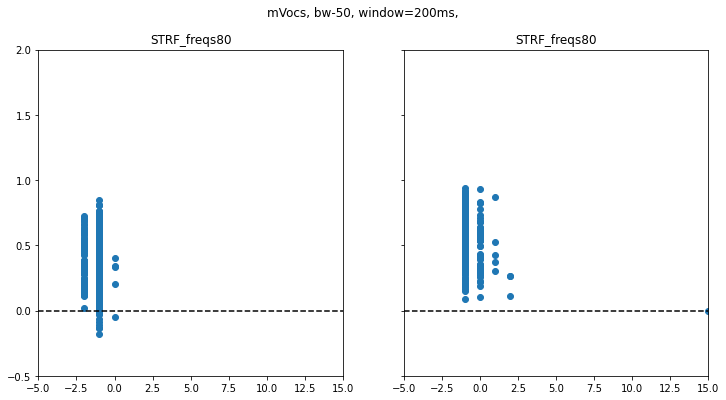

In [8]:
model_name = 'STRF_freqs80'
threshold = 0.5
mVocs = True
lmbda_column = 'lmbda'
corr_column = 'mVocs_normalized_test_cc'
identifiers = [
    'mel_mVocs_trf_lags300_bw50_naplib_matched',
    'mel_ucsf_mVocs_trf_lags200_bw50_regression_improved',
]

num_models = len(identifiers)
fig, axes = plt.subplots(1, num_models, figsize=(12, 6), sharey=True)
lag = 200
bw = 50
for i, identifier in enumerate(identifiers):
    # identifier = f'ucsf_mVocs_trf_lags{lag}_bw{bw}_regression_improved'
    strf_obj = Correlations(model_name + '_' + identifier)
    data = strf_obj.get_highly_tuned_channels(strf_obj.data, threshold=threshold, mVocs=mVocs)
    axes[i].scatter(data[lmbda_column], data[corr_column])
    axes[i].axhline(0, color='black', linestyle='--')
    axes[i].set_ylim(-0.5, 2)
    axes[i].set_xlim(-5, 15)
    axes[i].set_title(model_name)
title = "mVocs" if mVocs else "timit"
plt.suptitle(title+f", bw-{bw}, window={lag}ms,")

In [7]:
strf_obj.data

,session,channel,bin_width,delay,num_freqs,tmin,tmax,lmbda,test_cc_raw,normalizer,mVocs_test_cc_raw,mVocs_normalizer,mVocs_normalized_test_cc,mVocs_null_mean,mVocs_null_std,N_sents
0,180413.0,0.0,50.0,0.0,80.0,0.0,300.0,-1.0,0.0,0.0,0.023742,-0.007198,NaN,0.004282,0.113042,500.0
1,180413.0,1.0,50.0,0.0,80.0,0.0,300.0,-1.0,0.0,0.0,-0.003926,0.002096,-0.085762,-0.007042,0.081968,500.0
2,180413.0,2.0,50.0,0.0,80.0,0.0,300.0,-1.0,0.0,0.0,0.046579,-0.001019,NaN,0.001140,0.076688,500.0
3,180413.0,3.0,50.0,0.0,80.0,0.0,300.0,-1.0,0.0,0.0,0.007760,-0.004867,NaN,-0.004299,0.074310,500.0
4,180413.0,4.0,50.0,0.0,80.0,0.0,300.0,-1.0,0.0,0.0,0.016566,-0.010654,NaN,-0.000890,0.078888,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1589,200318.0,40.0,50.0,0.0,80.0,0.0,300.0,-1.0,0.0,0.0,0.015829,0.109254,0.047889,0.045603,0.087255,500.0
1590,200318.0,41.0,50.0,0.0,80.0,0.0,300.0,-1.0,0.0,0.0,0.022286,0.066384,0.086498,0.002156,0.069096,500.0
1591,200318.0,42.0,50.0,0.0,80.0,0.0,300.0,-1.0,0.0,0.0,0.009017,0.114778,0.026614,0.029390,0.076957,500.0
1592,200318.0,43.0,50.0,0.0,80.0,0.0,300.0,-1.0,0.0,0.0,0.025264,0.081775,0.088348,0.004187,0.076258,500.0


### mel-scales comparison

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from torchaudio.functional import _mel_scale_fbanks

def mel_scale_kaldi(freq_hz):
    """Kaldi mel scale formula"""
    return 1127.0 * np.log(1 + freq_hz / 700.0)

def mel_scale_slaney(freq_hz):
    """Slaney mel scale from librosa/ESSENTIA"""
    f_min = 0.0
    f_sp = 200.0 / 3  # 66.6667 Hz per mel below 1000Hz
    min_log_hz = 1000.0
    min_log_mel = (min_log_hz - f_min) / f_sp  # Mel value at 1000 Hz
    
    mel = np.where(
        freq_hz < min_log_hz,
        (freq_hz - f_min) / f_sp,
        min_log_mel + np.log(freq_hz / min_log_hz) / np.log(6.4) * 27.0,
    )
    return mel

freqs = np.linspace(0, 8000, 8001)

mel_kaldi = mel_scale_kaldi(freqs)
mel_slaney = mel_scale_slaney(freqs)

plt.plot(freqs, mel_kaldi, label="Kaldi mel scale")
plt.plot(freqs, mel_slaney, label="Slaney mel scale")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Mel value")
plt.title("Kaldi vs Slaney Mel Scales")
plt.legend()
plt.grid(True)
plt.show()


ImportError: cannot import name '_mel_scale_fbanks' from 'torchaudio.functional' (/home/ahmedb/.conda/envs/cent7/2020.11-py38/wav2letter/lib/python3.8/site-packages/torchaudio/functional/__init__.py)